In [138]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,MissingIndicator,KNNImputer,IterativeImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import set_config
from scipy import stats
import seaborn as sns

In [59]:
df = pd.read_csv('titanic.csv')#,usecols=['Age','Survived'])

In [36]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
255,635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9000,NaN,S
171,603,0,1,"Harrington, Mr. Charles H",male,NaN,0,0,113796,42.4000,NaN,S
295,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S
461,707,1,2,"Kelly, Mrs. Florence ""Fannie""",female,45.0,0,0,223596,13.5000,NaN,S
158,572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0,2,0,11769,51.4792,C101,S


In [4]:
df.isnull().sum()

In [60]:
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'],inplace=True)

In [38]:
df.isnull().mean()*100 #approx 20% values missing in age, so can't apply CCA(complete case analysis)

Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Embarked     0.224467
dtype: float64

In [61]:
df['Age_mean'] = df['Age'].fillna(df['Age'].mean())

In [62]:
df['Age_median'] = df['Age'].fillna(df['Age'].median())

In [43]:
df[['Age','Age_mean','Age_median']].boxplot() #outliers have been introduced in data, IQR has also shrunk

<AxesSubplot:>

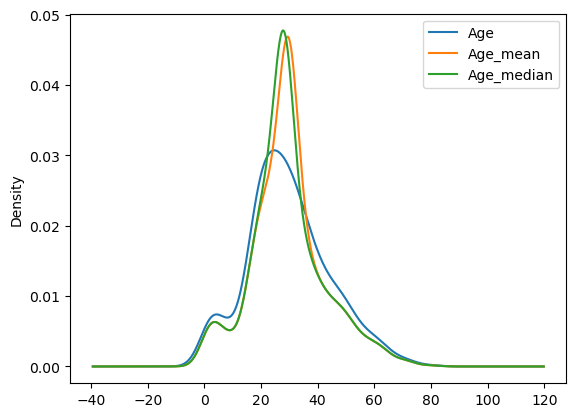

In [16]:
df[['Age','Age_mean','Age_median']].plot(kind='kde') #variance introduced in data,coz of which distribution shape has changed.Check cov and corr among different features
plt.show()

In [63]:
df['Age_random'] = df['Age']
df['Age_random'][df['Age_random'].isnull()] =df['Age'].dropna().sample(df['Age'].isna().sum()).values #sample of 177 values from age is drawn and filled in place of NA of age_random using subscript

C:\Users\arsal\AppData\Local\Temp\ipykernel_33640\3821325775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age_random'][df['Age_random'].isnull()] =df['Age'].dropna().sample(df['Age'].isna().sum()).values #sample of 177 values from age is drawn and filled in place of NA of age_random using subscript


In [64]:
df.tail(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_mean,Age_median,Age_random
886,0,2,male,NaN,0,0,0.0,S,29.699118,28.0,6.0
887,0,2,male,NaN,0,0,0.0,S,29.699118,28.0,29.0
888,0,1,male,39.0,0,0,0.0,S,39.000000,39.0,39.0
889,0,1,male,NaN,0,0,0.0,S,29.699118,28.0,8.0
890,0,1,male,38.0,0,0,0.0,S,38.000000,38.0,38.0


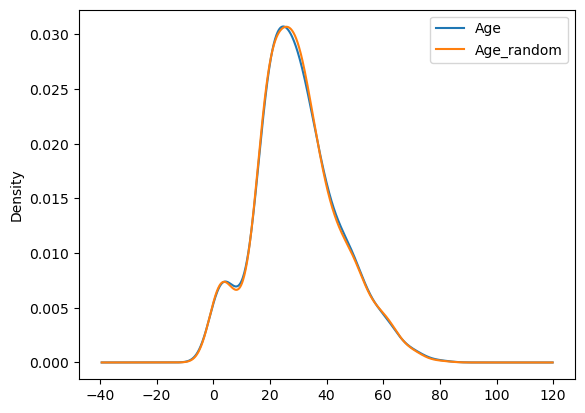

In [33]:
df[['Age','Age_random']].plot(kind='kde')
labels = ['Age','Age_random']
plt.legend(labels)
plt.show()

In [65]:
df_temp = df[['Age_mean','Age_median','Age_random']]

In [66]:
df.drop(columns=['Age_mean','Age_median','Age_random','Embarked'],inplace=True)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,female,35.0,0,0,512.3292,C
1,1,1,male,36.0,0,1,512.3292,C
2,1,1,male,35.0,0,0,512.3292,C
3,0,1,male,19.0,3,2,263.0000,S
4,1,1,female,23.0,3,2,263.0000,S
...,...,...,...,...,...,...,...,...
886,0,2,male,NaN,0,0,0.0000,S
887,0,2,male,NaN,0,0,0.0000,S
888,0,1,male,39.0,0,0,0.0000,S
889,0,1,male,NaN,0,0,0.0000,S


### MissingIndicator

In [67]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(columns=['Survived']),df['Survived'],test_size=0.2,random_state=42)

In [68]:
mi = MissingIndicator()
x_train_trans = mi.fit_transform(x_train)
x_test_trans = mi.transform(x_test)

In [69]:
x_train_trans.shape

(712, 1)

In [70]:
x_train.isnull().sum()

Pclass      0
Sex         0
Age       142
SibSp       0
Parch       0
Fare        0
dtype: int64

In [78]:
x_train['Age_NA'] = x_train_trans
x_train.drop(columns=['Sex'],inplace=True)
x_test.drop(columns=['Sex'],inplace=True)

In [79]:
x_test['Age_NA'] = x_test_trans

In [82]:
clf = LogisticRegression()
si = SimpleImputer()
x_train_trans = si.fit_transform(x_train)
x_test_trans = si.transform(x_test)
clf.fit(x_train_trans,y_train) #use SI to avoid error of NAN in data which model can't handle

y_pred = clf.predict(x_test_trans)
accuracy_score(y_test,y_pred) #71% as opposed to 64% previously

0.7150837988826816

### using MissingIndicator within SimpleImputer 

In [83]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(columns=['Survived']),df['Survived'],test_size=0.2,random_state=42)

In [84]:
x_train.drop(columns=['Sex'],inplace=True)
x_test.drop(columns=['Sex'],inplace=True)

In [85]:
clf = LogisticRegression()
si = SimpleImputer(add_indicator=True)
x_train_trans = si.fit_transform(x_train)
x_test_trans = si.transform(x_test)
clf.fit(x_train_trans,y_train) #use SI to avoid error of NAN in data which model can't handle

y_pred = clf.predict(x_test_trans)
accuracy_score(y_test,y_pred)

0.7150837988826816

In [88]:
x_test_trans[:,-1 #missing value indicator in last colummn added by simple imputer

array([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0.])

### Use multivariate imputation on Age using KNN

In [130]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(columns=['Survived']),df['Survived'],test_size=0.2,random_state=42)

In [131]:
x_train.drop(columns=['Sex'],inplace=True)
x_test.drop(columns=['Sex'],inplace=True)

#### using Uniform weights

In [133]:
knn = KNNImputer(n_neighbors=5,weights='uniform') #5 nearest rows will be calculated and thier values will be weighed uniformly i.e mean value will be assigned to nan
x_train_trans = knn.fit_transform(x_train)
x_test_trans = knn.transform(x_test)

clf = LogisticRegression()
clf.fit(x_train_trans,y_train)
y_pred = clf.predict(x_test_trans)
accuracy_score(y_test,y_pred)

0.7094972067039106

#### using distance weights

In [134]:
knn1 = KNNImputer(n_neighbors=5,weights='distance') #5 nearest rows will be calculated and thier values will be weighed acc to distance
x_train_trans1 = knn1.fit_transform(x_train)
x_test_trans1 = knn1.transform(x_test)

clf1 = LogisticRegression()
clf1.fit(x_train_trans1,y_train)
y_pred1 = clf1.predict(x_test_trans1)
accuracy_score(y_test,y_pred1)

0.7150837988826816

### use gridsearchcv

In [90]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(columns=['Survived']),df['Survived'],test_size=0.2,random_state=42)

In [112]:
x_train
trf = ColumnTransformer(transformers=[('si',SimpleImputer(strategy='mean'),['Age']),
                                     ('ohe',OneHotEncoder(dtype=np.int32),['Sex']),],
                       remainder='passthrough')

pipe = Pipeline([('trans',trf),
                ('clf',LogisticRegression())])

pipe.fit(x_train,y_train)
y_pred = pipe.predict(x_test)#clf.predict(x_test_trans)
accuracy_score(y_test,y_pred)

C:\Users\arsal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8379888268156425

In [ ]:
param_grid = { 'trans__si__strategy':['mean','median'],
            'clf__C': [0.1,1.0,10,100] }

grid_search = GridSearchCV(pipe,param_grid,cv=10)
grid_search.fit(x_train,y_train)
grid_search.best_params_

In [124]:
grid_search.best_score_

0.7865805946791862

In [116]:
clf.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [127]:
res = pd.DataFrame(grid_search.cv_results_)

### Using Iterative imputer MICE - multivariate imputer by chained equations

In [143]:
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
x_train = np.array([[1,2],[np.nan,4],[3,6],[4,np.nan]])
x_test = np.array([[np.nan,2],[5,np.nan],[np.nan,16],[10,np.nan]])

In [144]:
imp = IterativeImputer(max_iter=10,random_state=42)
x_train_trans = imp.fit_transform(x_train)
x_test_trans = imp.transform(x_test)
np.round(x_test_trans,1)

array([[ 1.,  2.],
       [ 5., 10.],
       [ 8., 16.],
       [10., 20.]])

In [145]:
np.round(x_train_trans,1)

array([[1., 2.],
       [2., 4.],
       [3., 6.],
       [4., 8.]])